# Chapter 2: Current frequency of threshold exceedance

In this chapter the current frequency of exceeding the threshold determined in chapter 1 wil be analysed. This is done by looking at the available observation data of the catchment area of the Wien River. This observation data is available through eWaterCycle. As determined in chapter 1, the Wien River is designed for a 1000-year discharge return period. The observation data is unlikely to cover a period of 1000 years, so we will need to extrapolate it to estimate the discharge corresponding to a 1000-year return period and determine the return period of the previously established threshold. 

## General

First of all, some general python and eWaterCycle libraries need to be imported.

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print
import seaborn as sns
sns.set()

# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

eWaterCycle provides access to the Caravan dataset. This dataset contains data on rainfall, potential evaporation and discharge for all the catchments in the different Camel datasets. The Caravan dataset contains a Camel dataset of the catchment of the Wien River. This catchment area is loaded below:

In [2]:
camelsgb_id = "lamah_208082"

The start and end date of the experiment need to be specified. The start and end date of the available observation data are determined further below, and are hardcoded in the following cell:

In [3]:
experiment_start_date = "1981-08-01T00:00:00Z"
experiment_end_date = "2020-12-31T00:00:00Z"

The forcing data can be generated or previously generated data can be loaded:

In [4]:
# Even though we don't use caravan data as forcing, we still call it forcing
# because it is generated using the forcing module of eWaterCycle
forcing_path_caravan = Path.home() / "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

# If someone has prepared forcing for you, this path needs to be changed to that location. 
prepared_forcing_path_caravan_central = Path("location/of/forcing/data")

In [5]:
# option one: generate forcing data
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(
#     start_time=experiment_start_date,
#     end_time=experiment_end_date,
#     directory=forcing_path_caravan,
#     basin_id=camelsgb_id,
# )


# option two or three: load data that you or someone else generated previously
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(Path("/home/thirza/forcing/lamah_208082/caravan"))

print(camelsgb_forcing)

CaravanForcing(
    start_time='1981-08-01T00:00:00Z',
    end_time='2030-12-31T00:00:00Z',
    directory=PosixPath('/home/thirza/forcing/lamah_208082/caravan'),
    shape=PosixPath('/home/thirza/forcing/lamah_208082/caravan/lamah_208082.shp'),
    filenames={
        'tasmax': 'lamah_208082_1981-08-01_2030-12-31_tasmax.nc',
        'tas': 'lamah_208082_1981-08-01_2030-12-31_tas.nc',
        'tasmin': 'lamah_208082_1981-08-01_2030-12-31_tasmin.nc',
        'Q': 'lamah_208082_1981-08-01_2030-12-31_Q.nc',
        'pr': 'lamah_208082_1981-08-01_2030-12-31_pr.nc',
        'evspsblpot': 'lamah_208082_1981-08-01_2030-12-31_evspsblpot.nc'
    }
)

Above, it can be seen that the forcing data contains precipitation, potential evaporation, discharge and the near-surface temperatures (tas). For determining the threshold exceedance frequency, only the discharge data are used. The discharge data is loaded from the forcing below. The data contains the maximum discharge values per day.

['1981-08-01T00:00:00.000000000' '1981-08-02T00:00:00.000000000'
 '1981-08-03T00:00:00.000000000' ... '2020-12-29T00:00:00.000000000'
 '2020-12-30T00:00:00.000000000' '2020-12-31T00:00:00.000000000']

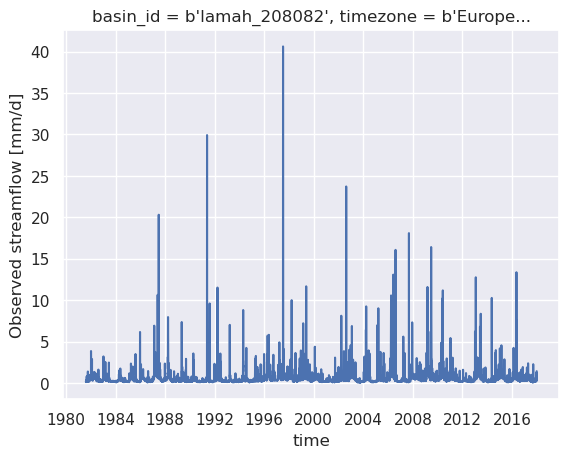

In [6]:
#quick plot of the discharge data. 
ds_forcing = xr.open_mfdataset([camelsgb_forcing['Q'], ])
ds_forcing["Q"].plot()
print(ds_forcing['time'].values)

Since the threshold values determined in chapter 2 are in m3/s, the observed discharge data, now in mm/d, is converted to m3/s as well.

Text(0, 0.5, 'observed streaflow [$m^3$/s]')

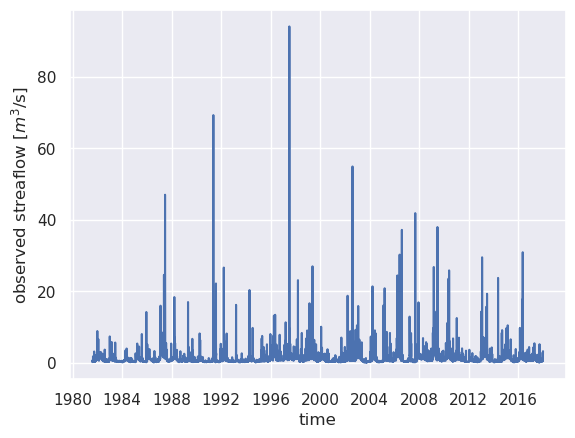

In [7]:
catchment_area = ds_forcing["area"].values

# go from mm/day to m3/s
discharge = []
for i in range(len(ds_forcing["Q"].values)):
    discharge.append((ds_forcing["Q"].values[i] * catchment_area * 1000) / (24 * 60 * 60))

x = ds_forcing["time"].values
y = discharge

plt.plot(x,y)
plt.xlabel('time')
plt.ylabel('observed streaflow [$m^3$/s]')

The maximum discharge of the observed data can be extracted.

In [8]:
print(f'The maximum observed discharge in the observed data is {max(discharge):.3f} m3/s.') 

The maximum observed discharge in the observed data is 94.052 m3/s.

The observed discharge data can be used to calculate the returnperiods of the normally distributed threshold values. This is done using the Generalized Extreme Value distribution. The return period of the mean threshold value of 530 m3/s is calculated below: 

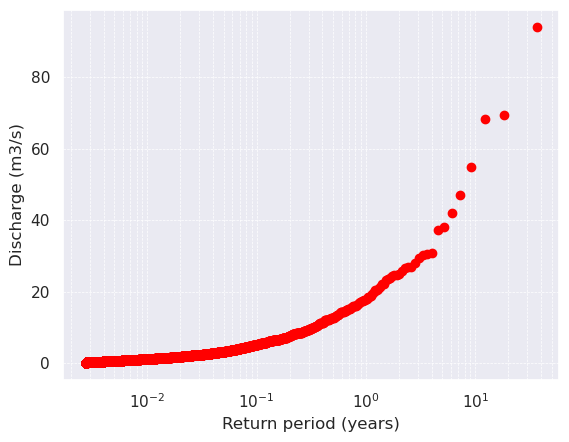

In [9]:
import scipy.stats as stats
import math
# # discharge data > 20 m³/s
# data = [value for value in discharge if value > 20]

# all discharge data
cleaned_discharge = [x for x in discharge if not math.isnan(x)]
data = cleaned_discharge
# print(data)

# # maximum annual discharge
# data = [x for x in maxdischarge if not math.isnan(x)]
# # print(data)



# scatter of data
# Sort data from high to low
sorted_data = np.sort(data)[::-1]  # Sorteer aflopend

#calculate return periods
n = len(sorted_data)
rank = np.arange(1, n + 1)
return_periods_days = (n + 1) / rank
return_periods_years = return_periods_days / 365


# Generalized Extreme Value (GEV) distribution 
shape, loc, scale = stats.genextreme.fit(data)

# Define threshold value
discharge_threshold = np.linspace(0.0001, 600, 601)

return_period = []
prob = []
for i in range(len(discharge_threshold)):
# calculate exceedance probability in years
    p = 1 - stats.genextreme.cdf(discharge_threshold[i], shape, loc=loc, scale=scale)
    prob.append(p)
# calculate return period in years
    T = 1 / (p *365) 
    return_period.append(T)
# print(return_period)

plt.xscale('log')
# plt.plot(return_period, discharge_threshold)
plt.scatter(return_periods_years, sorted_data, color="red", label="Waarden")
plt.xlabel('Return period (years)')
plt.ylabel('Discharge (m3/s)')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

Below both the normal distribution of the exceedance threshold values and the return periods of discharges are plotted below. This graph shows the return period and the probability density are related to the discharge. A discharge value more to the right of the normal distribution, has a higher return period, but also has a longer probability of actually causing flooding of the U4 subway line.

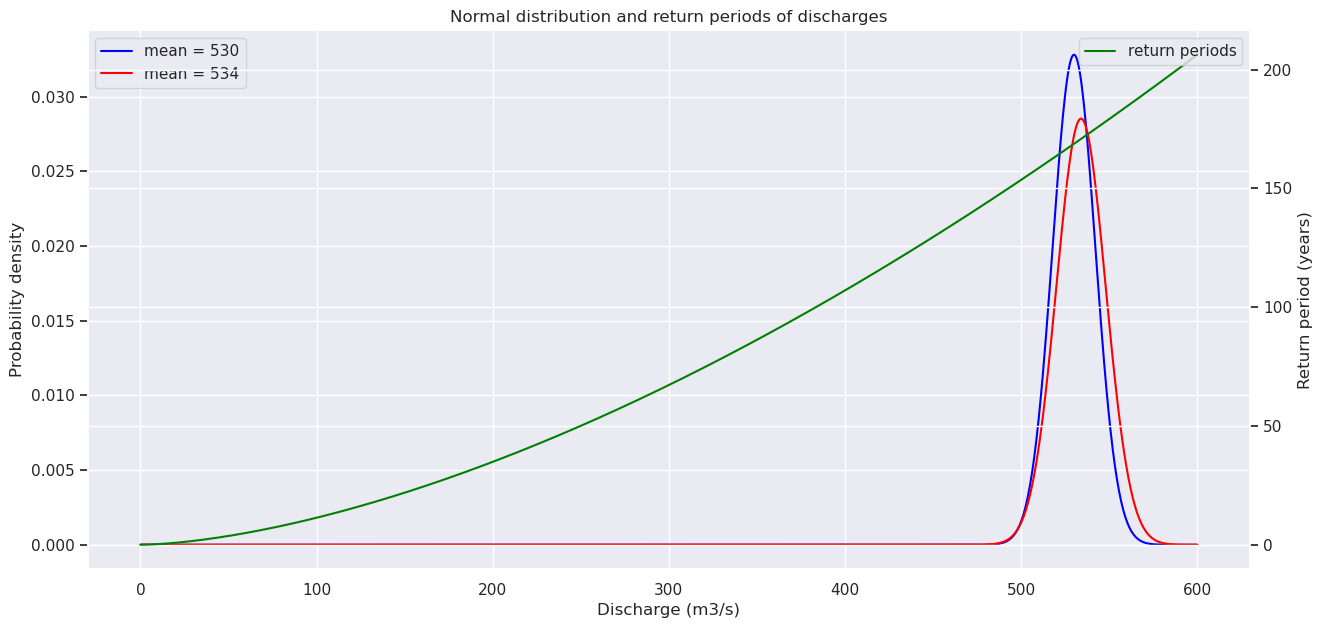

In [10]:
#1
mean = 530
p5 = 510  # 5th percentile
p95 = 550  # 95th percentile

#Calculate standard deviation
z_5 = stats.norm.ppf(0.05)  # -1.645
z_95 = stats.norm.ppf(0.95)  # 1.645
std_dev = (p95 - mean) / z_95  # σ = (550 - 530) / 1.645
x = np.linspace(0, 600, 1000)
y = stats.norm.pdf(x, mean, std_dev)

#2
mean_2 = 534
p5_2 = 511  # 5th percentile
p95_2 = 557  # 95th percentile

#Calculate standard deviation
z_5 = stats.norm.ppf(0.05)  # -1.645
z_95 = stats.norm.ppf(0.95)  # 1.645
std_dev_2 = (p95_2 - mean_2) / z_95  # σ = (550 - 530) / 1.645
x_2 = np.linspace(0, 600, 1000)
y_2 = stats.norm.pdf(x_2, mean_2, std_dev_2)


fig, ax1 = plt.subplots(figsize=(15, 7))

# ax1.plt.figure(figsize=(8, 5))
ax1.plot(x, y, label="mean = 530", color='blue')
ax1.plot(x_2, y_2, label="mean = 534", color='red')

# # Mark the 5th and 95th percentiles
# plt.axvline(p5, color='red', linestyle='dashed')
# plt.axvline(p95, color='red', linestyle='dashed')
# plt.axvline(mean, color='orange', linestyle='dashed')
# plt.axvline(p5_2, color='green', linestyle='dashed')
# plt.axvline(p95_2, color='green', linestyle='dashed')
# plt.axvline(mean_2, color='orange', linestyle='dashed')


ax1.set_xlabel("Discharge (m3/s)")
ax1.set_ylabel("Probability density")

# Make second axis
ax2 = ax1.twinx()

ax2.plot(discharge_threshold, return_period, label="return periods", color='green')
ax2.set_ylabel("Return period (years)")
ax2.tick_params(axis='y')

plt.title(f"Normal distribution and return periods of discharges")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Toon de plot
plt.grid(True)
plt.show()